<a href="https://colab.research.google.com/github/PravinHaligonda/random-fun/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import SubsetRandomSampler

In [2]:
def get_cifar10_dataset(batch_size, num_workers=0, validation_fraction=None, train_transform=None, test_transform=None):
  if train_transform is None:
    train_transform = transforms.ToTensor()
  if test_transform is None:
    test_transform = transforms.ToTensor()

  train_dataset = datasets.CIFAR10(root="cifar10", train=True, download=True, transform=train_transform)
  valid_dataset = datasets.CIFAR10(root="cifar10", train=True, download=True, transform=test_transform)
  test_dataset = datasets.CIFAR10(root="cifar-10", train=False, download=True, transform=test_transform)

  if validation_fraction is not None:
    num = int(validation_fraction * 50000)
    train_indices = torch.arange(0, 50000 - num)
    valid_indices = torch.arange(50000 - num, 50000)
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)

    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, sampler=valid_sampler)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, sampler=train_sampler)
  else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

  if validation_fraction is not None:
    return train_loader, valid_loader, test_loader
  else:
    return train_loader, test_loader


In [3]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 200
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [7]:
set_all_seeds(RANDOM_SEED)

In [8]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:
train_loader, valid_loader, test_loader = get_cifar10_dataset(BATCH_SIZE, train_transform=train_transforms, test_transform=test_transforms, num_workers=2, validation_fraction=0.1)

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting cifar-10/cifar-10-python.tar.gz to cifar-10


In [10]:
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


In [11]:
class AlexNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

In [12]:
model = AlexNet(num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:

def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


In [14]:

import time
def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')


    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list


In [15]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

Epoch: 001/200 | Batch 0000/0175 | Loss: 2.3024
Epoch: 001/200 | Batch 0100/0175 | Loss: 2.2897
Epoch: 001/200 | Train: 19.02% | Validation: 19.50%
Time elapsed: 0.80 min
Epoch: 002/200 | Batch 0000/0175 | Loss: 1.9228
Epoch: 002/200 | Batch 0100/0175 | Loss: 2.0369
Epoch: 002/200 | Train: 31.82% | Validation: 31.58%
Time elapsed: 1.60 min
Epoch: 003/200 | Batch 0000/0175 | Loss: 1.7385
Epoch: 003/200 | Batch 0100/0175 | Loss: 1.5934
Epoch: 003/200 | Train: 43.78% | Validation: 43.84%
Time elapsed: 2.41 min
Epoch: 004/200 | Batch 0000/0175 | Loss: 1.4438
Epoch: 004/200 | Batch 0100/0175 | Loss: 1.4648
Epoch: 004/200 | Train: 52.86% | Validation: 53.06%
Time elapsed: 3.18 min
Epoch: 005/200 | Batch 0000/0175 | Loss: 1.4159
Epoch: 005/200 | Batch 0100/0175 | Loss: 1.1932
Epoch: 005/200 | Train: 58.26% | Validation: 58.66%
Time elapsed: 3.98 min
Epoch: 006/200 | Batch 0000/0175 | Loss: 1.2473
Epoch: 006/200 | Batch 0100/0175 | Loss: 1.2922
Epoch: 006/200 | Train: 62.08% | Validation: 61.5

In [17]:

def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


def show_examples(model, data_loader, unnormalizer=None, class_dict=None):


    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)

    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))

    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")

    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

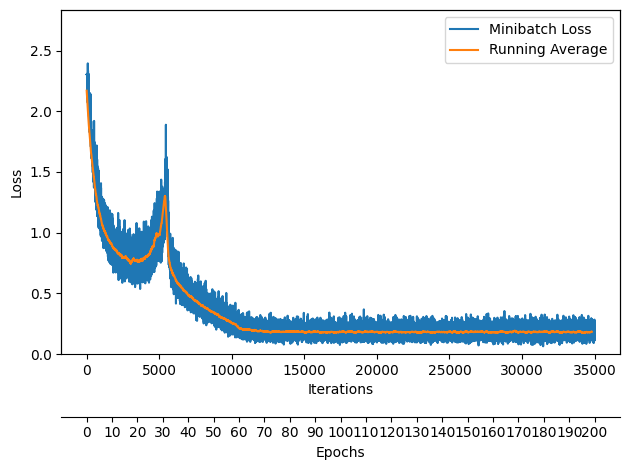

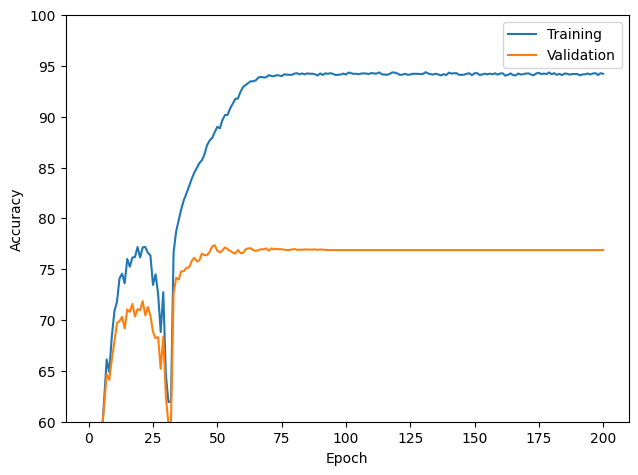

In [18]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [20]:


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.

        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


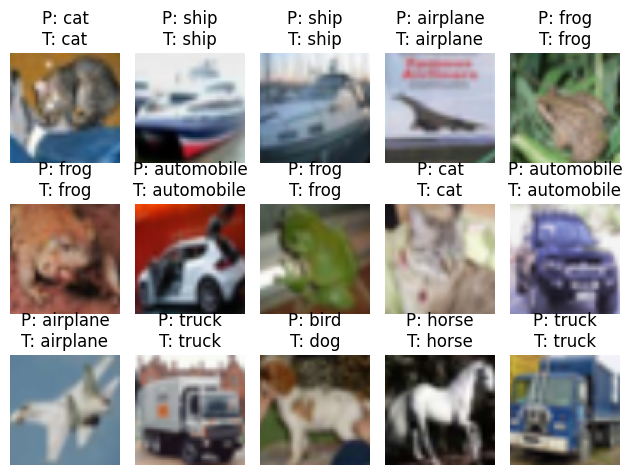

In [21]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

In [24]:
from itertools import product
def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

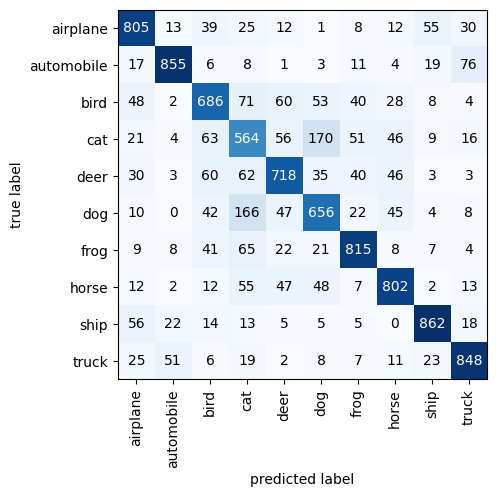

In [25]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()